In [1]:
import torch
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import plotnine as gg
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
import seaborn as sns
import tree
from data import rosetta_data_loader

import sys
import argparse
import re
import logging

import pandas as pd
pd.set_option('display.max_colwidth', None)

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

torch.hub.set_dir('/data/rsg/chemistry/jyim/.cache/torch')

INFO: Using numpy backend


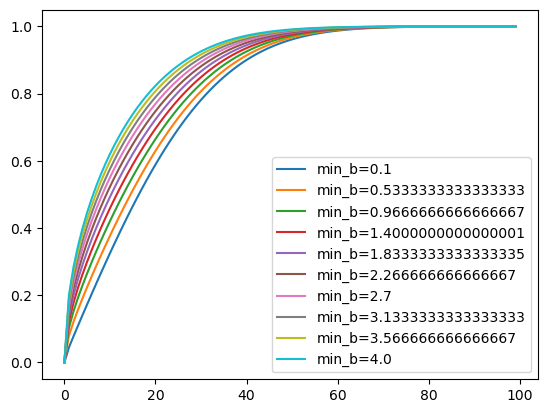

In [18]:
# min_b = 0.1
for min_b in np.linspace(0.1, 4.0, 10):
    max_b = 20.0
    num_t = 100
    ts = np.linspace(0.0, 1.0, num_t)
    bs = min_b + ts*(max_b - min_b)
    bar_bs = ts*min_b + (1/2)*(ts**2)*(max_b-min_b)
    std = np.sqrt(1 - np.exp(-bar_bs))
    plt.plot(std, label=f'min_b={min_b}')
plt.legend()

Text(0.5, 1.0, 'Std with linear schedule')

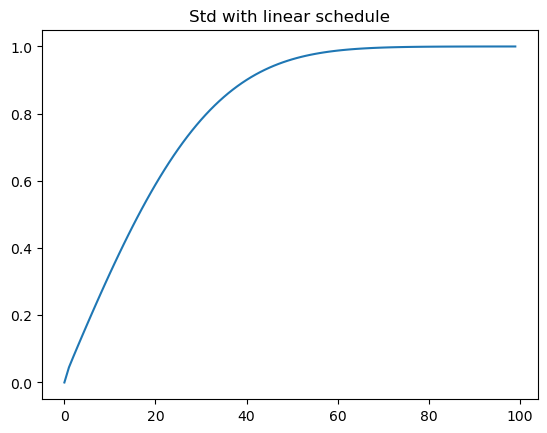

In [15]:

plt.title('Std with linear schedule')

# Read conditional sampling results

In [2]:
all_csvs = []
base_protdiff_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/'
results_dir = os.path.join(
    base_protdiff_dir,
    # Directory where samples live. Typically of form,
    # samples/<ckpt_name>/inpainting/<date_time>
    'samples/no_seq_diff_3/13D_11M_2022Y_18h_13m_02s/inpainting/21D_11M_2022Y_00h_24m_52s'
)

print(f'Reading samples from {results_dir}')
for motif_name in os.listdir(results_dir):
    if '.' in motif_name:
        continue
    motif_dir = os.path.join(results_dir, motif_name)
    for i,sample_name in enumerate(os.listdir(motif_dir)):
        if '.' in sample_name:
            continue
        csv_path = os.path.join(motif_dir, sample_name, 'mpnn', 'sc_results.csv')
        if os.path.exists(csv_path):
            design_csv = pd.read_csv(csv_path, index_col=0)
            design_csv['motif_name'] = motif_name
            design_csv['sample_id'] = i
            all_csvs.append(design_csv)
results_df = pd.concat(all_csvs)

Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/no_seq_diff_3/13D_11M_2022Y_18h_13m_02s/inpainting/21D_11M_2022Y_00h_24m_52s


In [23]:
# Filter designs that pass coarse motif threshold.
motif_rmsd_cutoff = 3.0
filtered_df = results_df[results_df.motif_rmsd < motif_rmsd_cutoff]

# Sort by high to low of scTM
scaffold_sc_df = filtered_df.sort_values('tm_score', ascending=False)

# Take the top scTM ProteinMPNN/ESMFold example for each motif and sample number.
scaffold_sc_df = scaffold_sc_df.groupby(['motif_name', 'sample_id']).first().reset_index()

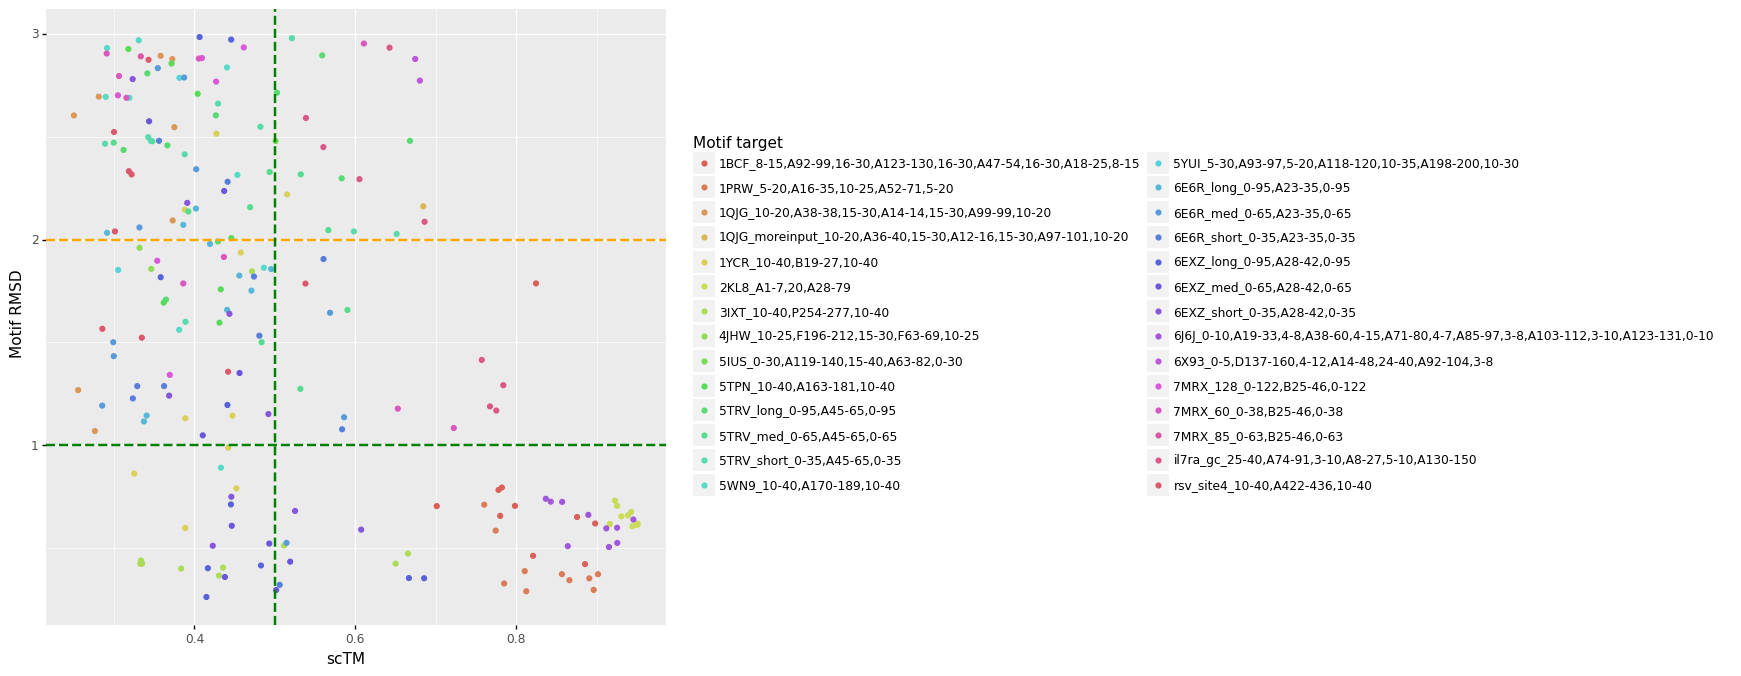

In [24]:
# Plot
p = (
    gg.ggplot(
        scaffold_sc_df,
        gg.aes('tm_score', 'motif_rmsd', color='motif_name')
    )
    + gg.geom_point()
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Motif RMSD')
    + gg.labels.labs(color='Motif target')
    + gg.themes.theme(
        figure_size=(8, 8),
    )
    + gg.geoms.geom_hline(
        yintercept=1.0,
        size=1.0,
        linetype='dashed',
        color='green',
    )
    + gg.geoms.geom_hline(
        yintercept=2.0,
        size=1.0,
        linetype='dashed',
        color='orange',
    )
    + gg.geoms.geom_vline(
        xintercept=0.5,
        size=1.0,
        linetype='dashed',
        color='green',
    )
)

print(p)

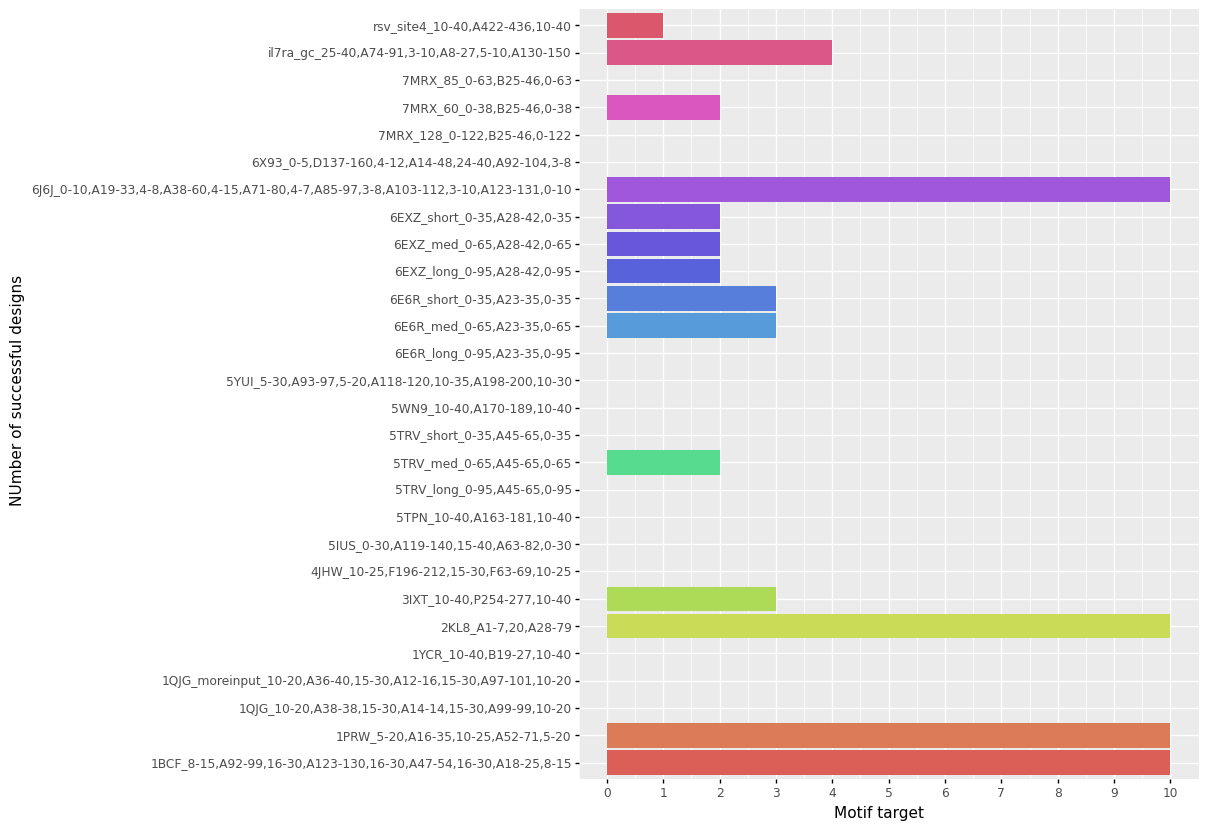

In [55]:
scaffold_sc_df['success'] = (scaffold_sc_df.motif_rmsd < 2.0) & (scaffold_sc_df.tm_score > 0.5)
success_df = scaffold_sc_df.groupby(['motif_name']).success.agg(np.sum).reset_index()
p = (
    gg.ggplot(
        success_df,
        gg.aes('motif_name', 'success', fill='motif_name')
    )
    + gg.geom_col(show_legend=False)
    + gg.coord_flip()
    + gg.labels.xlab('NUmber of successful designs')
    + gg.labels.ylab('Motif target')
    + gg.labels.labs(color='Motif target')
    + gg.themes.theme(
        figure_size=(8, 10),
    )
    + gg.scales.scale_y_continuous(
        breaks=range(11)
    )
)
print(p)